# #Launching modes from a fiber into free space

In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import rspie as rs
from matplotlib import pyplot as plt
import cmasher as cm
import os, re
from subprocess import check_output

In [ ]:
import http.client, urllib
import sys

def send_message(message, app='Ringer'):
    token_dict = {'Ringer': 'aqxvnvfq42adpf78g9pwmphse9c2un',
                'Focus':  'aysoawteigoym1trggunrmpwzh4oo8',
                'Alerts': 'a1195pxoe4g4kscq21h37e2hbkg4j8'}
    app_token = token_dict[app]
    conn = http.client.HTTPSConnection("api.pushover.net",443)
    endpoint = "/1/messages.json"
    conn.request("POST", endpoint,
      urllib.parse.urlencode({
        "token": app_token,
        "user": "uqhx6qfvn87dtfz5dhk71hf2xh1iwu",
        "message": message,
      }), { "Content-type": "application/x-www-form-urlencoded" })
    return conn.getresponse().read().decode()

def send_count_to_watch(count):
    conn = http.client.HTTPSConnection("api.pushover.net",443)
    conn.request("POST", "/1/glances.json",
      urllib.parse.urlencode({
        "token": "aiwr9jyu15mj4cwtcguayavru2jn43",
        "user": "uqhx6qfvn87dtfz5dhk71hf2xh1iwu",
        "count": count,
      }), { "Content-type": "application/x-www-form-urlencoded" })
    return conn.getresponse().read().decode()

send_message('finished!')

dict_keys([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (6, 1), (6, 2), (7, 1), (7, 2), (8, 1), (9, 1)])

## ##Loading the output from monitors with spatial data

### ###Just a lonesome fiber

In [ ]:
fname = r'C:\Users\lab_pc_cryo\Documents\Photonic_Tools\fiber_launcher\mptmp_m3_eden.dat'
x_coords, y_coords, z_coords, num_array = rs.load_3d_dat(fname)
mid_x_index = int(len(x_coords)/2)
mid_y_index = int(len(y_coords)/2)
mid_z_index = int(len(z_coords)/2)

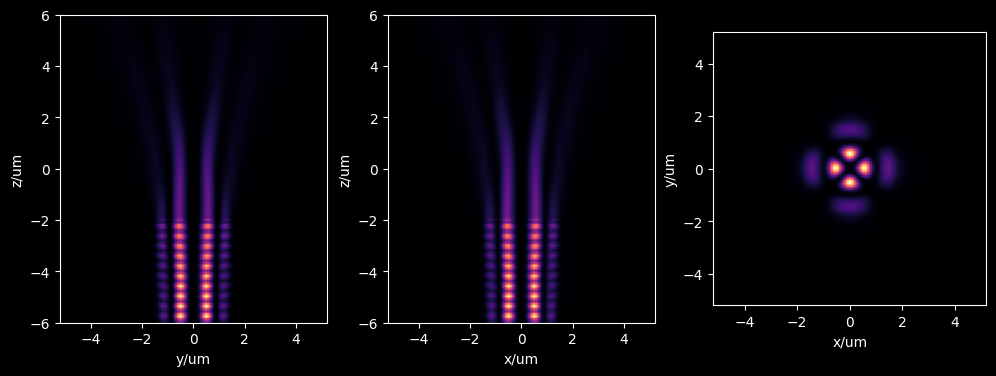

In [ ]:
yzslice = num_array[mid_x_index,:,:].T
yzextent = (y_coords[0], y_coords[-1], z_coords[0], z_coords[-1])
xzslice = num_array[:,mid_y_index,:].T
xzextent = (x_coords[0], x_coords[-1], z_coords[0], z_coords[-1])
xyslice = num_array[:,:,mid_z_index].T
xyextent = (x_coords[0], x_coords[-1], y_coords[0], y_coords[-1])
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
for idx, (data, extent, label) in enumerate(zip([yzslice, xzslice, xyslice], [yzextent, xzextent, xyextent], ['yz', 'xz', 'xy'])):
    ax[idx].imshow(data, 
    origin='lower',
    extent=extent,
    cmap='magma',
    vmin=0,
    vmax=np.max(data)
    )
    ax[idx].set_xlabel('%s/um' % label[0])
    ax[idx].set_ylabel('%s/um' % label[1])
plt.show()

### ###Fiber launching on metasurface (single mode)

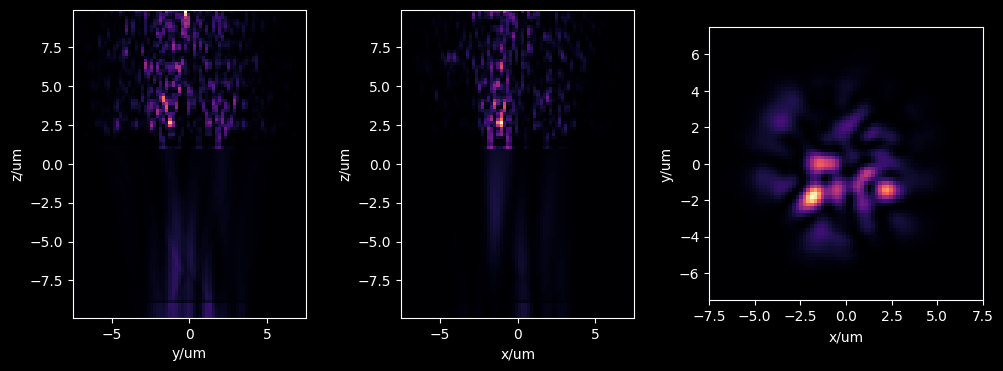

In [24]:
fname = r'C:\Users\lab_pc_cryo\Documents\Photonic_Tools\fiber_and_metal\bptmp_m5_eden.dat'
x_coords, y_coords, z_coords, num_array = rs.load_3d_dat(fname)
mid_x_index = int(len(x_coords)/2)
mid_y_index = int(len(y_coords)/2)
mid_z_index = int(len(z_coords)/2)
yzslice = num_array[mid_x_index,:,:].T
yzextent = (y_coords[0], y_coords[-1], z_coords[0], z_coords[-1])
xzslice = num_array[:,mid_y_index,:].T
xzextent = (x_coords[0], x_coords[-1], z_coords[0], z_coords[-1])
xyslice = num_array[:,:,mid_z_index].T
xyextent = (x_coords[0], x_coords[-1], y_coords[0], y_coords[-1])
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
for idx, (data, extent, label) in enumerate(zip([yzslice, xzslice, xyslice], [yzextent, xzextent, xyextent], ['yz', 'xz', 'xy'])):
    # data = np.log(data)
    ax[idx].imshow(data, 
    origin='lower',
    extent=extent,
    cmap='magma',
    vmin=0,
    vmax=np.max(data)
    )
    ax[idx].set_xlabel('%s/um' % label[0])
    ax[idx].set_ylabel('%s/um' % label[1])
    # if label[1] == 'z':
    #     ax[idx].set_ylim(0, 7.5)
plt.show()

### ###Fiber launching on metasurface (all modes)

In [46]:
from subprocess import check_output, Popen
import os

In [68]:
import time

In [143]:
def run_metal(simulscript, config, mon_index, tau_kill=10):
    script_dir = os.path.split(simulscript)[0]
    os.chdir(script_dir)
    cmd = ['bsimw32', simulscript, 'wait=0']
    extra_params = []
    for k, v in config.items():
        vtype = type(v)
        if vtype == int:
            extra_params.append('%s=%d' % (k, v))
        elif vtype == float:
            extra_params.append('%s=%f' % (k, v))
        else:
            extra_params.append('%s=%s' % (k, v))
    cmd = cmd + extra_params
    os.remove('log.txt')
    proc = Popen(cmd)
    start_time = time.time()
    aborted = False
    while True:
        if os.path.exists('log.txt'):
            status = open('log.txt','r').read()
        poll = proc.poll()
        runtime = time.time() - start_time
        if runtime > tau_kill:
            if 'setting' not in status:
                print("Stale sim, aborting.")
                aborted = True
                proc.kill()
                break
        if poll == 0:
            break
        time.sleep(0.5)
    if not aborted:
        fname = r'C:\Users\lab_pc_cryo\Documents\Photonic_Tools\fiber_and_metal\%s_m%d_eden.dat' % (config['prefix'], mon_index)
        x_coords, y_coords, z_coords, num_array = rs.load_3d_dat(fname)
        mid_x_index = int(len(x_coords)/2)
        mid_y_index = int(len(y_coords)/2)
        mid_z_index = int(len(z_coords)/2)
        return x_coords, y_coords, z_coords, num_array
    else:
        return False

In [146]:
simulscript = r'C:\Users\lab_pc_cryo\Documents\Photonic_Tools\fiber_and_metal\fiber_and_metal.ind'
script_txt = open(simulscript, 'r').read()
monitor_index = int([s for s in script_txt.split('\n') if 'time_monitor ' in s][0].split(' ')[-1])
vars = '\n'.join([line.strip() for line in script_txt.split('\n') if '=' in line])
model_vars = rs.selfref_def_parser(vars)
no_mo_modes = False
totem = {}
start_time = time.time()
tested_modes = list(range(0,11))
tested_radial_modes = list(range(1,15))
for launch_mode in tested_modes:
    for radial_mode in tested_radial_modes:
        print("Running mode %d, radial mode %d" % (launch_mode, radial_mode))
        config = {'launch_mode': launch_mode,
                'launch_mode_radial': radial_mode,
                'prefix': 'metal_fiber_%d_%d' % (launch_mode, radial_mode)}
        afiber = run_metal(simulscript, config, monitor_index)
        if not afiber:
            print("No more radial modes, jumping to next mode family.")
            if radial_mode == 1:
                no_mo_modes = True
            break
        else:
            totem[(launch_mode, radial_mode)] = afiber
    if no_mo_modes:
        print("No more mode families, exiting.")
        break
end_time = time.time()
compendium = {'data': totem,
              'tested_radial_modes': tested_radial_modes,
              'tested_modes': tested_modes,
              'script_txt': script_txt,
              'model_vars': model_vars,
              'config': config,
              'time_taken/s': end_time - start_time}
_ = send_message('Finished running all modes.')

Running mode 0, radial mode 1
Running mode 0, radial mode 2
Running mode 0, radial mode 3
Stale sim, aborting.
No more radial modes, jumping to next mode family.
Running mode 1, radial mode 1
Running mode 1, radial mode 2
Stale sim, aborting.
No more radial modes, jumping to next mode family.
Running mode 2, radial mode 1
Running mode 2, radial mode 2
Stale sim, aborting.
No more radial modes, jumping to next mode family.
Running mode 3, radial mode 1
Stale sim, aborting.
No more radial modes, jumping to next mode family.
No more mode families, exiting.


In [89]:
import pickle

In [147]:
pickle.dump(compendium, open('totem-2.pkl', 'wb'))

(0, 1)


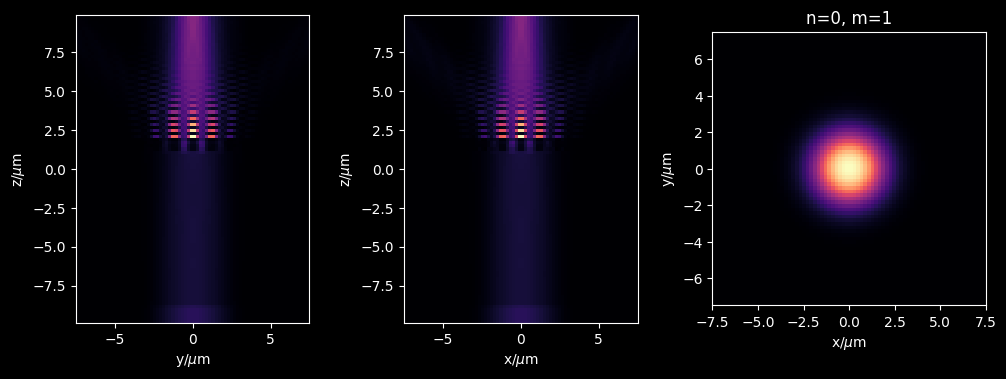

(0, 2)


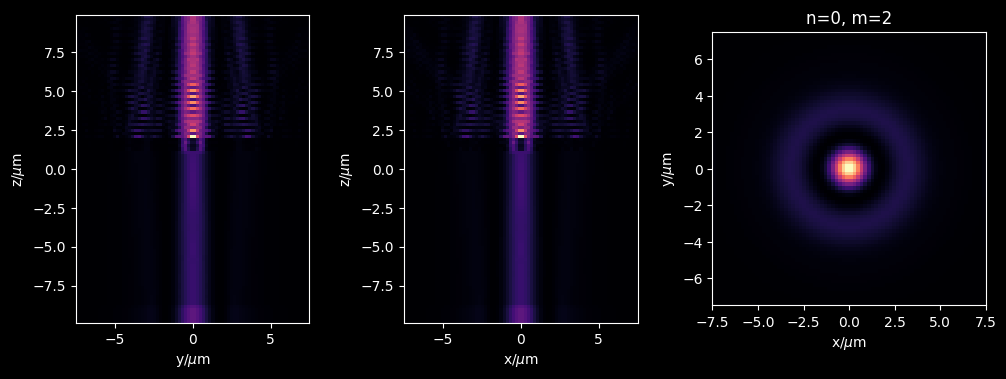

(1, 1)


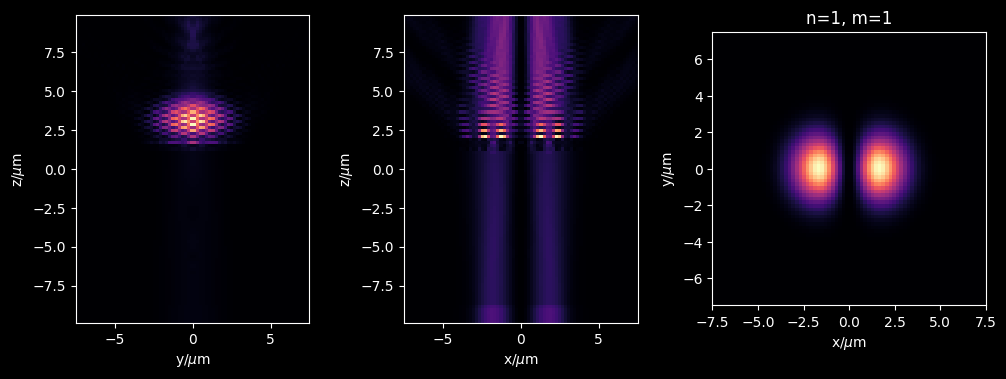

(2, 1)


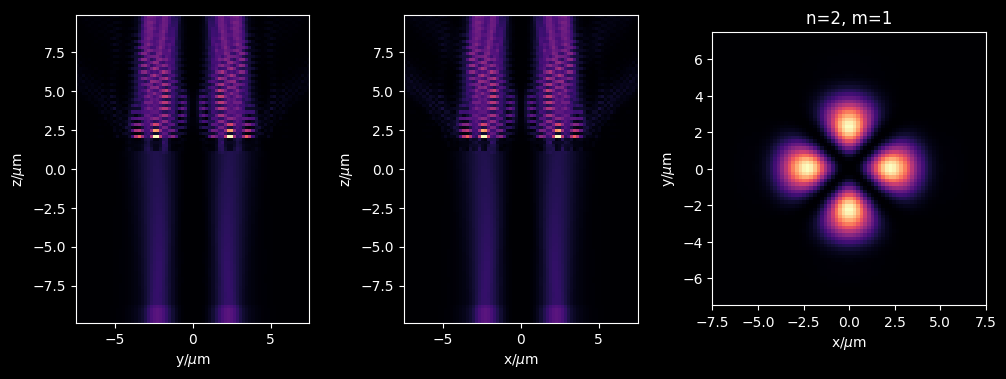

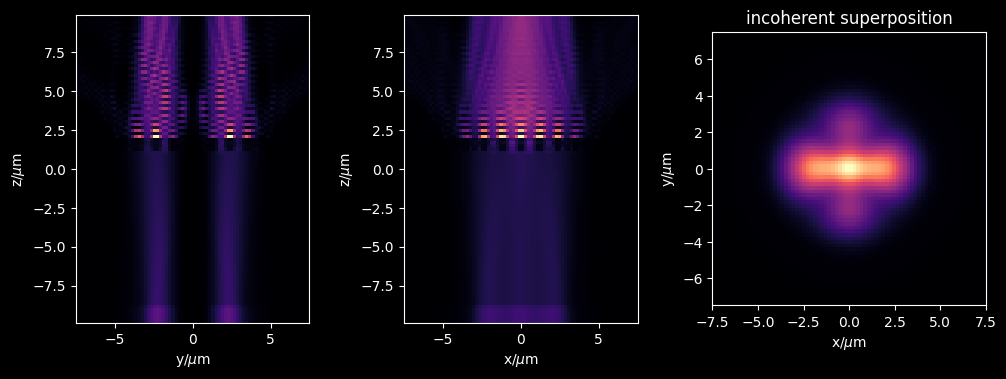

In [150]:
totem = compendium['data']
for idx, key in enumerate(totem):
    print(key)
    afiber = totem[key]
    x_coords, y_coords, z_coords, num_array = afiber
    if idx == 0:
        tot_density = np.full_like(num_array, 0)
    tot_density += num_array
    mid_x_index = int(len(x_coords)/2)
    mid_y_index = int(len(y_coords)/2)
    mid_z_index = int(len(z_coords)/2)
    yzslice = num_array[mid_x_index,:,:].T
    yzextent = (y_coords[0], y_coords[-1], z_coords[0], z_coords[-1])
    xzslice = num_array[:,mid_y_index,:].T
    xzextent = (x_coords[0], x_coords[-1], z_coords[0], z_coords[-1])
    xyslice = num_array[:,:,mid_z_index].T
    xyextent = (x_coords[0], x_coords[-1], y_coords[0], y_coords[-1])
    fig, ax = plt.subplots(ncols=3, figsize=(12,4))
    for idx, (data, extent, label) in enumerate(zip([yzslice, xzslice, xyslice], [yzextent, xzextent, xyextent], ['yz', 'xz', 'xy'])):
        # data = np.log(data)
        ax[idx].imshow(data, 
        origin='lower',
        extent=extent,
        cmap='magma',
        vmin=0,
        vmax=np.max(data)
        )
        ax[idx].set_xlabel('%s/$\mu$m' % label[0])
        ax[idx].set_ylabel('%s/$\mu$m' % label[1])
        if label == 'xy':
            ax[idx].set_title('n=%d, m=%d' % key)
    figfname = os.path.join('figs', '%d_%d.png' % key)
    plt.savefig(figfname)
    plt.show()

num_array = tot_density
xzslice = num_array[:,mid_y_index,:].T
xzextent = (x_coords[0], x_coords[-1], z_coords[0], z_coords[-1])
xyslice = num_array[:,:,mid_z_index].T
xyextent = (x_coords[0], x_coords[-1], y_coords[0], y_coords[-1])
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
for idx, (data, extent, label) in enumerate(zip([yzslice, xzslice, xyslice], [yzextent, xzextent, xyextent], ['yz', 'xz', 'xy'])):
    # data = np.log(data)
    ax[idx].imshow(data, 
    origin='lower',
    extent=extent,
    cmap='magma',
    vmin=0,
    vmax=np.max(data)
    )
    ax[idx].set_xlabel('%s/$\mu$m' % label[0])
    ax[idx].set_ylabel('%s/$\mu$m' % label[1])
    if label == 'xy':
        ax[idx].set_title('incoherent superposition')
figfname = os.path.join('figs', 'incoherent_super.png')
plt.savefig(figfname)
plt.show()

## ##Calculating modes in a step-index fiber

In [9]:
extra_config = {
    'mode_method': 2,
    'free_space_wavelength': 0.633,
    'Core_radius':1.2,
    'Core_index': 1.46147,
    'Cladding_index': 1.45804,
    'polarization': 0,
    'mode_output_format': 'OUTPUT_REAL_IMAG',
    'launch_type':'LAUNCH_GAUSSIAN',
    'launch_tilt': 1
    }
cmd_params = {
    'prefix': 'SM600',
    'mode_set': '0-2'
}
basedir = 'd:\\Zia_Lab\\Codebase\\rspie\\circuits'
modes = waveguide_modes(extra_config,
        cmd_params, basedir, verbose=True)

There should be about 0.6 modes.


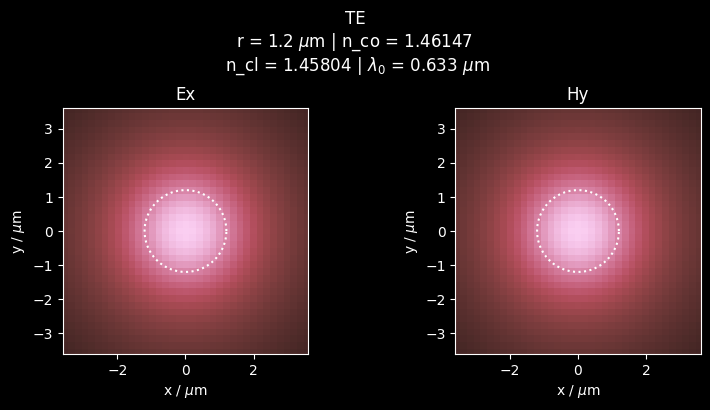

In [10]:
mode_files = modes['mode_files']
num_modes = len(mode_files)
full_title = 'r = {Core_radius} $\mu$m | n_co = {Core_index} \n n_cl = {Cladding_index} | $\lambda_0$ = {free_space_wavelength} $\mu$m'.format(**extra_config)
num_cols = int(np.ceil(np.sqrt(num_modes)))
num_rows = int(np.ceil(num_modes/num_cols))
fig, ax = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
if 'polarization' in extra_config:
    if extra_config['polarization'] == 0:
        pol = 'TE'
    elif extra_config['polarization'] == 0:
        pol = 'TM'
    else:
        pol = ''
if num_modes == 1:
    ax = np.array([ax])
if len(ax.shape) == 1:
    ax = ax.reshape((1,ax.shape[0]))
job = []
radius = extra_config['Core_radius']
core_theta = np.linspace(0, 2*np.pi, 100)
core_x = radius*np.cos(core_theta)
core_y = radius*np.sin(core_theta)
for idx, filename in enumerate(mode_files):
    extent, lines, n_eff = load_mode_data(filename)
    if '_ex' in filename:
        field_component = 'Ex'
    elif '_hy' in filename:
        field_component = 'Hy'
    elif '_ey' in filename:
        field_component = 'Ey'
    elif '_hx' in filename:
        field_component = 'Hx'
    else:
        field_component = ''
    row = idx // num_cols
    col = idx % num_cols
    ax[row,col].set_ylabel('y / $\mu$m')
    ax[row,col].set_xlabel('x / $\mu$m')
    map_normalizer = max(np.max(lines), abs(np.min(lines)))
    ax[row,col].imshow(lines,
                extent=extent,
                cmap=cm.watermelon,
                aspect=1,
                vmin=-map_normalizer,
                vmax=map_normalizer,
                origin='lower')
    ax[row,col].plot(core_x, core_y, 'w:')
    ax[row,col].set_title(field_component)
    ax[row,col].set_xlim(-3*radius, 3*radius)
    ax[row,col].set_ylim(-3*radius, 3*radius)
    job.append((row,col))
for row in range(num_rows):
    for col in range(num_cols):
        if (row,col) not in job:
            ax[row,col].axis('off')
fig.suptitle('TE\n'+full_title)
plt.tight_layout()
plt.show()